In [3]:
# (1) LIc積固定時のIC毎の遅延ぱらつきシミュレーション
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor
import threading, time

from circuit_sim import circuit_sim

# スレッドごとの排他制御（ファイル書き込み用）
# lock = threading.Lock()

lic = 192.5
bias_vol_v = 0.5 * 10**(-3)

def run_simulation(i):
    time.sleep(i)

    sim_con = circuit_sim("jtl_base.cir")
    Ic = i * 10
    sim_con.new_make_jtl2(Ic, lic, bias_vol_v)
    sim_con.sim()
    netlist_file = f"jitter/jitter_{i}.cir"
    sim_con.output_netlist(netlist_file)

    diff_file = f"jitter/delays{i}.csv"
    sim_con.calc_jitter(
        ["P(B1|X1|X1|X35)", "P(B2|X1|X1|X35)"],
        ["P(B1|X2|X20|X35)", "P(B2|X2|X20|X35)"],
        40, diff_file, try_count=5000
    )

    data = pd.read_csv(diff_file)
    data[0] = data[0].apply(lambda x: 0 if abs(x) <= 1e-20 else x)
    data.to_csv(diff_file, index=False, header=False)

    # 出力ファイルへの同時書き込みを防止
    # with lock:
    #     with open("jitter.csv", "a") as f:
    #         f.write(f"{lic},{Ic},{mu},{std}\n")

# if __name__ == "__main__":
#     for i in range(1, 10 + 1):
#         open(f"jitter/delays{i}.csv", "w").close()

#     max_workers = 10 
#     indices = range(1, 10 + 1)

#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         executor.map(run_simulation, indices)


In [5]:
# (2) 臨界電流値毎の遅延ぱらつきヒストグラムの作成
plt.rcParams['font.family'] = ''
open("jitter.csv", "w").close()

for i in range(1, 10 + 1):
    Ic = i * 10
    diff_file = f"jitter/delays{i}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)

    with open("jitter.csv", "a") as f:
        f.write(f"{lic},{Ic},{mu},{std}\n")

    fig = plt.figure()
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label="Fitted Normal Distribution")
    plt.xlabel("Jitter Value")
    plt.ylabel("Density")
    plt.title("Fractuation of Propagation Time")
    plt.legend()
    plt.savefig(f"jitter/jitter_{i}.png")
    # plt.show()
    plt.close()

     lic   ic          mean        jitter
0  192.5   10 -5.838368e-14  4.874123e-13
1  192.5   20 -2.491698e-14  2.160379e-13
2  192.5   30 -2.286657e-14  1.366557e-13
3  192.5   40 -1.257702e-14  9.966029e-14
4  192.5   50 -1.173635e-14  8.945898e-14
5  192.5   60 -1.196539e-14  7.567294e-14
6  192.5   70 -7.174435e-15  6.935629e-14
7  192.5   80 -5.236047e-15  6.415355e-14
8  192.5   90 -6.022705e-15  6.104520e-14
9  192.5  100 -5.972194e-15  5.815532e-14


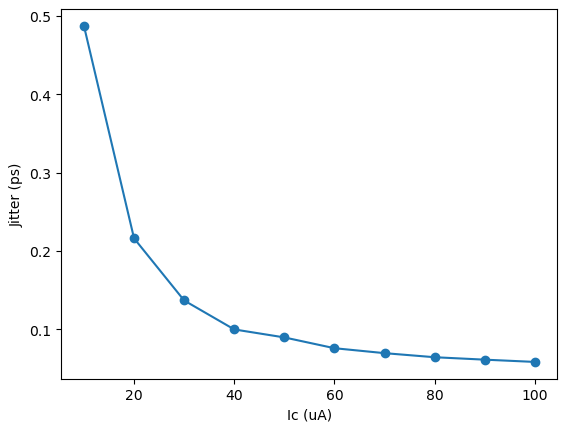

In [12]:
# (3) 臨界電流値毎のジッタのグラフの作成
file = "jitter.csv"
df = pd.read_csv(file,names=["lic","ic","mean","jitter"])
df_192 = df[df["lic"]==192.5]
print(df_192)

x = df_192["ic"]
y = df_192["jitter"]
y = y*10**12

fig = plt.figure()
plt.plot(x, y, marker="o")
plt.xlabel('Ic (uA)')
plt.ylabel('Jitter (ps)')
plt.show()
plt.close()